In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn import preprocessing
from collections import defaultdict
from collections import Counter

In [2]:
#import the train notebook
train1 = pd.read_csv('fraudTrain.csv', index_col = 'Unnamed: 0')
print('Training Dataset:',train1.shape,'\n')
train1.head()

Training Dataset: (1296675, 22) 



,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
#print a list of the column names to start grouping them
train_heads = train1.columns.to_numpy()
train_heads.tolist()

['trans_date_trans_time',
 'cc_num',
 'merchant',
 'category',
 'amt',
 'first',
 'last',
 'gender',
 'street',
 'city',
 'state',
 'zip',
 'lat',
 'long',
 'city_pop',
 'job',
 'dob',
 'trans_num',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud']

# Variable Grouping

## Identification Details -
* Cardholder Identifiers - 
    * Merge Columns `dob`, `first`, `last`, `gender`
    * `job`, `street`, `zip` & `cc_num` set as categorical variables
* Cardholder Vicinity -
    * Set `state` and `city` as categorical variables

## Transaction Details
* Transaction Timing Details related - `trans_date_trans_time` split into 
    * 1. `day` of the week as a Categorical Variable 
    * 2. `time` as a continuous series
* Transaction Type - 
    * `category`
    * `merchant`
* `city_state` and `city_pop` for comparison b/w city pop and fraud
* `amt` - shows spending patterns
* Use `lat`, `long`, `merch_lat`, `merch_long` to calculate distance between owner's residence and merchant

# Fraud Values
* `is_fraud` is the value to be predicted so it'll serve as the `y` value for the modelling

# 

In [4]:
#set features as categorical
train1[['state','city','job','cc_num','street','zip','merchant','category','trans_num']] = train1[['state','city','job','cc_num','street','zip','merchant','category','trans_num']].astype('category')

# drop trans_num because it plays the same role as index
train1 = train1.drop(columns = 'trans_num')

In [5]:
%%time
# merging columns into single string containing all personal info of the cardholder

train1['identifiers'] = train1[['first','last','gender','dob']].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

#set to category
train1['identifiers'] = train1['identifiers'].astype('category')

#drop columns which were merged
train1 = train1.drop(columns = ['first','last','gender','dob'])
train1.head()

CPU times: total: 1min 35s
Wall time: 1min 36s


,trans_date_trans_time,cc_num,merchant,category,amt,street,city,state,zip,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud,identifiers
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1325376018,36.011293,-82.048315,0,"Jennifer,Banks,F,1988-03-09"
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1325376044,49.159047,-118.186462,0,"Stephanie,Gill,F,1978-06-21"
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1325376051,43.150704,-112.154481,0,"Edward,Sanchez,M,1962-01-19"
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1325376076,47.034331,-112.561071,0,"Jeremy,White,M,1967-01-12"
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1325376186,38.674999,-78.632459,0,"Tyler,Garcia,M,1986-03-28"


# 

### transaction `day` & `time`

In [6]:
def daycalc(a):
    array = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','Monday']
    return array[a]

In [7]:
%%time
#set to datetime and get day index
train1['date_time'] = pd.to_datetime(train1['trans_date_trans_time'])

train1['day'] = train1['date_time'].dt.dayofweek
train1['day_of_the_week'] = train1['day'].apply(daycalc)
train1['day_of_the_week'] = train1['day_of_the_week'].astype('category')

# convert from nanoseconds to gigaseconds to reduce the impact of each time stamp on the models used later
train1['time1'] = train1['date_time'].dt.time
train1['time1'] = train1['date_time'].apply(lambda x: x.value)
train1['time'] = train1['time1'].divide(10**18)

#drop columns
train1 = train1.drop(columns = ['trans_date_trans_time','unix_time','time1','day','date_time'])
train1.head()

CPU times: total: 2.56 s
Wall time: 2.56 s


,cc_num,merchant,category,amt,street,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,identifiers,day_of_the_week,time
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,"Jennifer,Banks,F,1988-03-09",Tuesday,1.546301
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,"Stephanie,Gill,F,1978-06-21",Tuesday,1.546301
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,43.150704,-112.154481,0,"Edward,Sanchez,M,1962-01-19",Tuesday,1.546301
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,47.034331,-112.561071,0,"Jeremy,White,M,1967-01-12",Tuesday,1.546301
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,38.674999,-78.632459,0,"Tyler,Garcia,M,1986-03-28",Tuesday,1.546301


# 

### `distance`

In [8]:
%%time
import geopy.distance #import geopy to enable coordinate based calculations

#create a function to group coordinates so that they can be used by the geopy function
def dist_calc(row):
    owner_coords = (row['lat'], row['long'])
    merch_coords = (row['merch_lat'], row['merch_long'])
    return geopy.distance.geodesic(owner_coords, merch_coords).km #returns distance between owner and merchant in kilometers

#applying the function
train1['distance'] = train1.apply(dist_calc, axis=1)

#drop columns
train1 = train1.drop(columns = ['lat','long','merch_lat','merch_long'])

train1.head()

CPU times: total: 3min 9s
Wall time: 3min 9s


,cc_num,merchant,category,amt,street,city,state,zip,city_pop,job,is_fraud,identifiers,day_of_the_week,time,distance
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,561 Perry Cove,Moravian Falls,NC,28654,3495,"Psychologist, counselling",0,"Jennifer,Banks,F,1988-03-09",Tuesday,1.546301,78.773821
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,43039 Riley Greens Suite 393,Orient,WA,99160,149,Special educational needs teacher,0,"Stephanie,Gill,F,1978-06-21",Tuesday,1.546301,30.216618
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,594 White Dale Suite 530,Malad City,ID,83252,4154,Nature conservation officer,0,"Edward,Sanchez,M,1962-01-19",Tuesday,1.546301,108.102912
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,9443 Cynthia Court Apt. 038,Boulder,MT,59632,1939,Patent attorney,0,"Jeremy,White,M,1967-01-12",Tuesday,1.546301,95.685115
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,408 Bradley Rest,Doe Hill,VA,24433,99,Dance movement psychotherapist,0,"Tyler,Garcia,M,1986-03-28",Tuesday,1.546301,77.702395


# Replicating the same process for the `Test` dataset before encoding

In [9]:
%%time
test1 = pd.read_csv('fraudTest.csv', index_col = 'Unnamed: 0')
print('Testing Dataset:',test1.shape,'\n')

test1[['state','city','job','cc_num','street','zip','merchant','category','trans_num']] = test1[['state','city','job','cc_num','street','zip','merchant','category','trans_num']].astype('category')
test1['identifiers'] = test1[['first','last','gender','dob']].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

#set to category
test1['identifiers'] = test1['identifiers'].astype('category')

#drop columns which were merged
test1 = test1.drop(columns = ['first','last','gender','dob'])
#set to datetime and get day index
test1['date_time'] = pd.to_datetime(test1['trans_date_trans_time'])

test1['day'] = test1['date_time'].dt.dayofweek
test1['day_of_the_week'] = test1['day'].apply(daycalc)
test1['day_of_the_week'] = test1['day_of_the_week'].astype('category')

# convert from nanoseconds to gigaseconds to reduce the impact of each time stamp on the models used later
test1['time1'] = test1['date_time'].dt.time
test1['time1'] = test1['date_time'].apply(lambda x: x.value)
test1['time'] = test1['time1'].divide(10**18)

#drop columns
test1 = test1.drop(columns = ['trans_date_trans_time','unix_time','time1','day','date_time'])
#applying the function
test1['distance'] = test1.apply(dist_calc, axis=1)

#drop columns
test1 = test1.drop(columns = ['lat','long','merch_lat','merch_long'])
test1 = test1.drop(columns = 'trans_num')

test1.head()

Testing Dataset: (555719, 22) 

CPU times: total: 2min 6s
Wall time: 2min 6s


,cc_num,merchant,category,amt,street,city,state,zip,city_pop,job,is_fraud,identifiers,day_of_the_week,time,distance
0,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,351 Darlene Green,Columbia,SC,29209,333497,Mechanical engineer,0,"Jeff,Elliott,M,1968-03-19",Sunday,1.592742,24.613746
1,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,3638 Marsh Union,Altonah,UT,84002,302,"Sales professional, IT",0,"Joanne,Williams,F,1990-01-17",Sunday,1.592742,104.834043
2,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,9333 Valentine Point,Bellmore,NY,11710,34496,"Librarian, public",0,"Ashley,Lopez,F,1970-10-21",Sunday,1.592742,59.204796
3,3591919803438423,fraud_Haley Group,misc_pos,60.05,32941 Krystal Mill Apt. 552,Titusville,FL,32780,54767,Set designer,0,"Brian,Williams,M,1987-07-25",Sunday,1.592742,27.615117
4,3526826139003047,fraud_Johnston-Casper,travel,3.19,5783 Evan Roads Apt. 465,Falmouth,MI,49632,1126,Furniture designer,0,"Nathan,Massey,M,1955-07-06",Sunday,1.592742,104.423175


## Reviewing the data

In [11]:
train1.dtypes

cc_num             category
merchant           category
category           category
amt                 float64
street             category
city               category
state              category
zip                category
city_pop              int64
job                category
is_fraud              int64
identifiers        category
day_of_the_week    category
time                float64
distance            float64
dtype: object

In [12]:
# check for any null within training dataset
train1.isna().sum().sum()

0

In [13]:
test1.dtypes

cc_num             category
merchant           category
category           category
amt                 float64
street             category
city               category
state              category
zip                category
city_pop              int64
job                category
is_fraud              int64
identifiers        category
day_of_the_week    category
time                float64
distance            float64
dtype: object

In [14]:
#check for any nulls within test dataset
test1.isna().sum().sum()

0

In [15]:
train1_cat = train1.select_dtypes('category')
print(train1_cat.shape)
test1_cat = test1.select_dtypes('category')
print(test1_cat.shape)

(1296675, 10)
(555719, 10)


In [16]:
#count unique
train1_cat.nunique()

cc_num             983
merchant           693
category            14
street             983
city               894
state               51
zip                970
job                494
identifiers        983
day_of_the_week      7
dtype: int64

In [17]:
#dropping day of the week since we already have day in an ordinal form
train1_cat = train1_cat.drop(columns = 'day_of_the_week')
test1_cat = test1_cat.drop(columns = 'day_of_the_week')

In [18]:
train1_non_cat = train1.select_dtypes(exclude = 'category')
print(train1_non_cat.shape)
test1_non_cat = test1.select_dtypes(exclude = 'category')
print(train1_non_cat.shape)

(1296675, 5)
(1296675, 5)


In [21]:
train1_non_cat = train1_non_cat.drop(columns = 'is_fraud')
test1_non_cat = test1_non_cat.drop(columns = 'is_fraud')

In [22]:
fraud_train = pd.DataFrame(train1[['is_fraud']])
fraud_test = pd.DataFrame(test1[['is_fraud']])

# Encoding variables

In [23]:
from category_encoders.cat_boost import CatBoostEncoder
cbe_encoder = CatBoostEncoder()
cbe_encoder.fit(train1_cat, fraud_train)
cbe_train = cbe_encoder.transform(train1_cat)
cbe_test = cbe_encoder.transform(test1_cat)

In [24]:
%%time
from category_encoders.binary import BinaryEncoder
bi_coder = BinaryEncoder()
bi_coder.fit(train1_cat, fraud_train)
bi_train = bi_coder.transform(train1_cat)
bi_test = bi_coder.transform(test1_cat)

CPU times: total: 10 s
Wall time: 10 s


In [25]:
test_binary = pd.concat([test1_non_cat,bi_test,fraud_test], axis = 1)
test_cbe = pd.concat([test1_non_cat,cbe_test,fraud_test], axis = 1)

In [26]:
test_binary.head()

,amt,city_pop,time,distance,cc_num_0,cc_num_1,cc_num_2,cc_num_3,cc_num_4,cc_num_5,...,identifiers_1,identifiers_2,identifiers_3,identifiers_4,identifiers_5,identifiers_6,identifiers_7,identifiers_8,identifiers_9,is_fraud
0,2.86,333497,1.592742,24.613746,1,0,1,0,0,1,...,0,1,0,0,1,1,0,1,1,0
1,29.84,302,1.592742,104.834043,1,0,0,1,0,1,...,0,0,1,0,1,0,1,1,0,0
2,41.28,34496,1.592742,59.204796,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,1,0
3,60.05,54767,1.592742,27.615117,1,0,0,1,0,1,...,0,0,1,0,1,0,1,1,1,0
4,3.19,1126,1.592742,104.423175,0,1,1,1,0,0,...,1,1,1,0,0,1,0,0,1,0


In [27]:
test_cbe.head()

,amt,city_pop,time,distance,cc_num,merchant,category,street,city,state,zip,job,identifiers,is_fraud
0,2.86,333497,1.592742,24.613746,0.007686,0.001104,0.002424,0.007686,0.007686,0.006612,0.007686,0.008700,0.007686,0
1,29.84,302,1.592742,104.834043,0.006701,0.002741,0.002424,0.006701,0.006701,0.005701,0.006701,0.006888,0.006701,0
2,41.28,34496,1.592742,59.204796,0.002718,0.001168,0.001549,0.002718,0.002718,0.006647,0.002718,0.002910,0.002718,0
3,60.05,54767,1.592742,27.615117,0.000004,0.004298,0.003139,0.000004,0.000004,0.006585,0.000004,0.012294,0.000004,0
4,3.19,1126,1.592742,104.423175,0.005408,0.001209,0.002864,0.005408,0.005408,0.005157,0.005408,0.009788,0.005408,0


In [28]:
test_binary = test_binary.sample(frac = 0.5, random_state = 1015)
test_cbe = test_cbe.sample(frac = 0.5, random_state = 1015)

## SMOTE won't be performed on test data
### Test data exported to csv directly

In [29]:
%%time
test_binary.to_csv('test_binary.csv')
test_cbe.to_csv('test_cbe.csv')

CPU times: total: 5.75 s
Wall time: 5.77 s


## 

# `Balancing` and `Sampling` the Training Data

In [30]:
X_train_cbe = pd.concat([train1_non_cat,cbe_train], axis = 1)
X_train_binary = pd.concat([train1_non_cat, bi_train], axis = 1)

In [33]:
X_train_cbe = X_train_cbe.sample(frac = 0.5, random_state = 1015)
X_train_binary = X_train_binary.sample(frac = 0.5, random_state = 1015)

In [34]:
y = fraud_train.sample(frac = 0.5, random_state = 1015)

In [36]:
%%time
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

osample1 = SMOTE(random_state = 1015)
osample2 = SMOTETomek(random_state = 1015)
osample3 = SMOTEENN(random_state = 1015)

#codes used here for X and Y are as follows:
#1_1 : cbe_SMOTE
#1_2 : cbe_SMOTETOMEK
#1_3 : cbe_SMOTEENN
#2_1 : binary_SMOTE
#2_2 : binary_SMOTETOMEK
#2_3 : binary_SMOTEENN

X_1_1, y_1_1 = osample1.fit_resample(X_train_cbe, y)
X_2_1, y_2_1 = osample1.fit_resample(X_train_binary, y)
X_1_3, y_1_3 = osample3.fit_resample(X_train_cbe, y)

CPU times: total: 29.9 s
Wall time: 28.5 s


* %%time
* X_1_2, y_1_2 = osample2.fit_resample(X_train_cbe, y)
* X_2_2, y_2_2 = osample2.fit_resample(X_train_binary, y)
* X__2_3, y_2_3 = osample3.fit_resample(X_train_binary, y)

SMOTETomek ran for far too long, hence we chose to exclude this sampling method.

Additionally, SMOTEENN was very time and resource draining on the Binary Classified data, and was thus also excluded

##### 

In [37]:
cbe_SMOTE_train = pd.concat([X_1_1, y_1_1], axis = 1)
#cbe_SMOTETomek_train = pd.concat([X_1_2, y_1_2], axis = 1)
cbe_SMOTEENN_train = pd.concat([X_1_3, y_1_3], axis = 1)

binary_SMOTE_train = pd.concat([X_2_1, y_2_1], axis = 1)

#binary_SMOTETomek_train = pd.concat([X_2_2, y_2_2], axis = 1)
#binary_SMOTEENN_train = pd.concat([X__2_3, y_2_3], axis = 1)

In [38]:
%%time
cbe_SMOTE_train.to_csv('cbe_SMOTE_train.csv')
cbe_SMOTEENN_train.to_csv('cbe_SMOTEENN_train.csv')
binary_SMOTE_train.to_csv('binary_SMOTE_train.csv')
# binary_SMOTEENN_train.to_csv('binary_SMOTEENN_train.csv')

CPU times: total: 42.4 s
Wall time: 42.5 s


[Text(0.5, 0, 'SMOTE, Binary Encoded')]

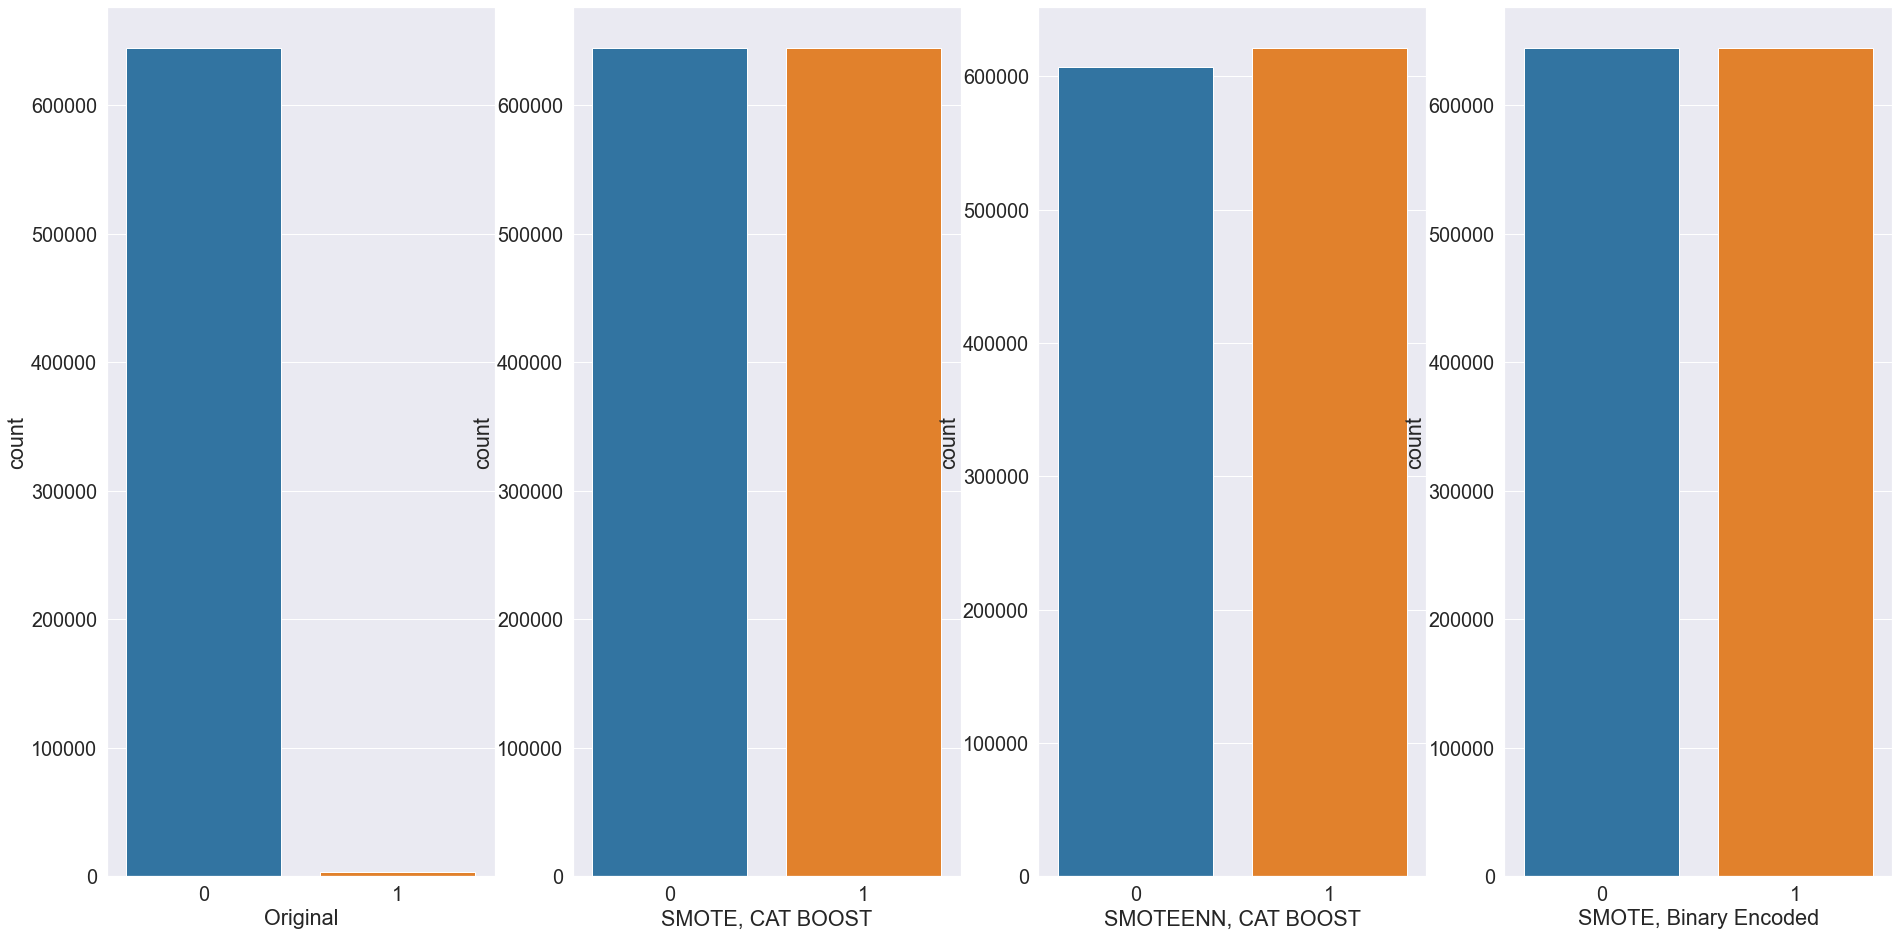

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.8) 
fig, axes =plt.subplots(1,4,figsize=(32,16))
sns.countplot(x = y['is_fraud'], ax = axes[0]).set(xlabel = "Original")
sns.countplot(x = y_1_1['is_fraud'], ax = axes[1]).set(xlabel = "SMOTE, CAT BOOST")
sns.countplot(x = y_1_3['is_fraud'], ax = axes[2]).set(xlabel = "SMOTEENN, CAT BOOST") 
sns.countplot(x = y_2_1['is_fraud'], ax = axes[3]).set(xlabel = "SMOTE, Binary Encoded")

# 